# Final Project Data Processing



In [3]:
#data_path = '/content/drive/My Drive/proyecto final/full_format_recipes.json'


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Cargar los datos
#data = pd.read_json(data_path)
data = pd.read_json('Downloads/full_format_recipes.json')

FileNotFoundError: File Downloads/full_format_recipes.json does not exist

In [41]:
#inspección de datos inicial
# Mostrar las primeras filas del DataFrame
data.head()

# Describir datos numéricos
data.describe()

# Ver información general de las columnas
data.info()

NameError: name 'data' is not defined

In [ ]:
# Histograma de calificaciones
plt.figure(figsize=(8, 6))
sns.histplot(data['rating'], bins=20, kde=True)
plt.title('Distribución de Calificaciones')
plt.show()

NameError: name 'data' is not defined

In [ ]:
#estudiar si valores nulos aportan a rating = 0 ????
# Contar cuántas recetas tienen rating = 0
rating_zero_count = data[data['rating'] == 0].shape[0]
print(f"Número de recetas con rating = 0: {rating_zero_count}")

In [ ]:
# Inspeccionar si hay valores nulos en otras columnas para rating = 0
data[data['rating'] == 0].isnull().sum()
#Esto sugiere que una proporción significativa de estas recetas con rating = 0 carece de información nutricional. Esto podría indicar que estas recetas están incompletas o mal registradas
#un rsting de 0 puede signficar comidas no evaluadas y/o datos validos pero incompletos.

,0
directions,0
fat,542
date,0
categories,0
calories,507
desc,696
protein,530
rating,0
title,0
ingredients,0


<ipython-input-8-f8056c09943b>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_rating_by_category.sort_values(by='rating', ascending=False).head(20),


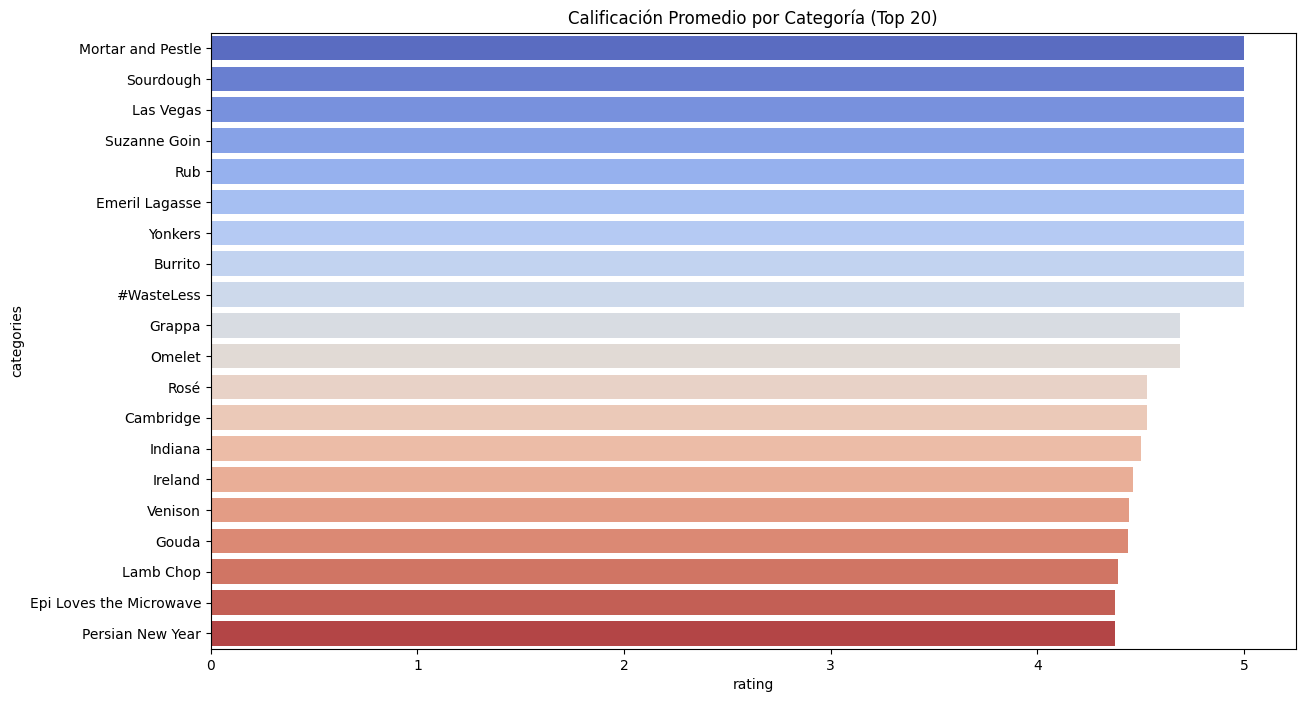

In [ ]:
# Expandir categorías a filas individuales
categories_exploded = data.explode('categories') #analizar cada categoría de forma independiente.

# Promedio de calificación por categoría
avg_rating_by_category = categories_exploded.groupby('categories')['rating'].mean().reset_index() #Agrupa las filas por categorías individuales y calcula rating para cada categoría.

# Visualización
plt.figure(figsize=(14, 8))
sns.barplot(data=avg_rating_by_category.sort_values(by='rating', ascending=False).head(20),
            x='rating', y='categories', palette='coolwarm')
plt.title('Calificación Promedio por Categoría (Top 20)')
plt.show()

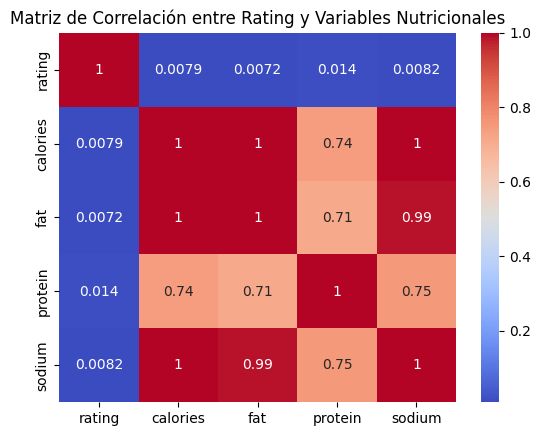

In [ ]:
# Matriz de correlación entre rating y variables numéricas
numerical_columns = ['rating', 'calories', 'fat', 'protein', 'sodium']
corr_matrix = data[numerical_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Matriz de Correlación entre Rating y Variables Nutricionales")
plt.show()
#matriz obviamente simetrica

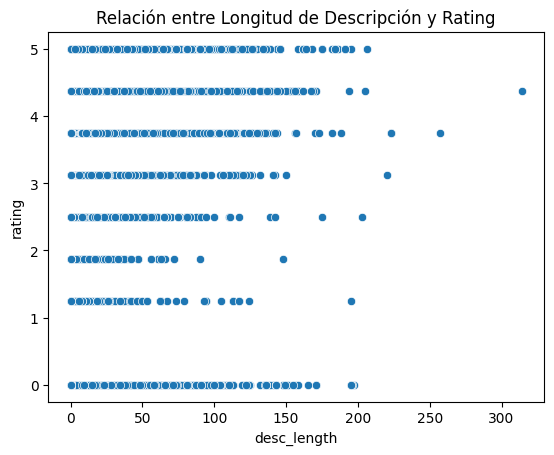

In [ ]:
# Longitud del texto en desc y su relación con rating
data['desc_length'] = data['desc'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
sns.scatterplot(x='desc_length', y='rating', data=data)
plt.title("Relación entre Longitud de Descripción y Rating")
plt.show()

Procesamiento de texto con spacy

SpaCy es más eficiente que otras librerias y ofrece un flujo más robusto para tareas de procesamiento de texto como tokenización, lematización, y eliminación de palabras vacías. Además, tiene un soporte más avanzado para trabajar con texto en el contexto de proyectos grandes.
Es muy util para mantener valor semantico a textos eliminando palabras "inutiles" semanticamente hablando.




In [ ]:
# Procesamiento de texto con SpaCy
import spacy

# Cargar el modelo en inglés
nlp = spacy.load('en_core_web_sm')

# Función de procesamiento con SpaCy
def spacy_preprocess(text):
    # Manejar listas de instrucciones y valores nulos
    if isinstance(text, list):  # Unir lista en una sola cadena
        text = " ".join(text)
    if not isinstance(text, str) or text.strip() == "":  # Verificar texto válido
        return ""

    # Procesar texto con SpaCy
    doc = nlp(text.lower())  # Convertir a minúsculas y procesar
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

# Establecer límite de procesamiento
num_recetas = 20129  # Cambiar este valor según el número de recetas a procesar

# Asegurarse de que no haya valores nulos en 'directions'
data['directions'] = data['directions'].fillna("")

# Aplicar el procesamiento solo a una parte de los datos
data_subset = data.head(num_recetas).copy()
# Reemplazar NaN en 'rating' por 0
data_subset['rating'].fillna(0, inplace=True)
data_subset['processed_directions'] = data_subset['directions'].apply(spacy_preprocess)

# Inspeccionar texto procesado
print(data_subset[['directions', 'processed_directions']].head())



<ipython-input-11-f6f571e1579b>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_subset['rating'].fillna(0, inplace=True)


                                          directions  \
0  [1. Place the stock, lentils, celery, carrot, ...   
1  [Combine first 9 ingredients in heavy medium s...   
2  [In a large heavy saucepan cook diced fennel a...   
3  [Heat oil in heavy large skillet over medium-h...   
4  [Preheat oven to 350°F. Lightly grease 8x8x2-i...   

                                processed_directions  
0  1 place stock lentil celery carrot thyme salt ...  
1  combine 9 ingredient heavy medium saucepan add...  
2  large heavy saucepan cook diced fennel onion b...  
3  heat oil heavy large skillet medium high heat ...  
4  preheat oven 350 ° f lightly grease 8x8x2 inch...  


3. vectorizacion de documentos

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Crear el vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Aplicar la vectorización al texto procesado
tfidf_matrix = tfidf_vectorizer.fit_transform(data_subset['processed_directions'])

# Mostrar la forma de la matriz resultante
print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")


TF-IDF Matrix Shape: (20129, 5000)


In [ ]:
import pandas as pd

# Convertir la matriz dispersa a un DataFrame de Pandas
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Mostrar las primeras filas
print(tfidf_df.head())

#mostrar solo palabras especificas
#palabras_interes = ['salt', 'oil', 'sugar']
#print(tfidf_df[palabras_interes].head())

#print(tfidf_df.iloc[0])  # Ver la primera receta


   0383   04   05   06   07        10  100  101  1022  104  ...  ziplock  \
0   0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   0.0  0.0  ...      0.0   
1   0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   0.0  0.0  ...      0.0   
2   0.0  0.0  0.0  0.0  0.0  0.159784  0.0  0.0   0.0  0.0  ...      0.0   
3   0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   0.0  0.0  ...      0.0   
4   0.0  0.0  0.0  0.0  0.0  0.109631  0.0  0.0   0.0  0.0  ...      0.0   

   zippered  ziti  zone  zucchini  árbol  ère  éclair  éclairs  épice  
0       0.0   0.0   0.0       0.0    0.0  0.0     0.0      0.0    0.0  
1       0.0   0.0   0.0       0.0    0.0  0.0     0.0      0.0    0.0  
2       0.0   0.0   0.0       0.0    0.0  0.0     0.0      0.0    0.0  
3       0.0   0.0   0.0       0.0    0.0  0.0     0.0      0.0    0.0  
4       0.0   0.0   0.0       0.0    0.0  0.0     0.0      0.0    0.0  

[5 rows x 5000 columns]


explicar pesos tf-idf,

cpu usr para word2vec y tf idf

gpu t4 para BERT

In [ ]:
#WORD2VEC
from gensim.models import Word2Vec
import numpy as np

# Tokenizar el texto para Word2Vec
tokenized_directions = data_subset['processed_directions'].apply(lambda x: x.split()) #separa palabras de un texto de una en una

# Entrenar el modelo Word2Vec
word2vec_model = Word2Vec(sentences=tokenized_directions, vector_size=100, window=5, min_count=2, workers=4)
#sentences -> lista de recetas tokenizadas
#vector size -> dimension de los vectores de palabras
#window -> palabras cinco a la izq y a la derecha
#min count= ignorar palabras que aparecen menos de dos
#workers ->  para acelerar el entrenamiento

# Crear función para obtener vectores promediados
#verificar que las palabras tienen embedings generados por word2vec
#si todas las palabras son desconocidas retorna un vector de 0s
#calcular promedio si todas son conocidas
def get_word2vec_embeddings(text, model):
    tokens = text.split()
    valid_tokens = [model.wv[token] for token in tokens if token in model.wv]
    if not valid_tokens:
        return np.zeros(model.vector_size)
    return np.mean(valid_tokens, axis=0)

# Aplicar Word2Vec a cada documento
word2vec_embeddings = np.array(data_subset['processed_directions'].apply(lambda x: get_word2vec_embeddings(x, word2vec_model)).tolist())

# Mostrar la forma de la matriz resultante
print(f"Word2Vec Embeddings Shape: {word2vec_embeddings.shape}")


Word2Vec Embeddings Shape: (20129, 100)


BERT

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

# Cargar el modelo y tokenizador preentrenados
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Función para obtener embeddings de BERT
def get_bert_embeddings(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Usar el embedding de [CLS]
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

# Aplicar la vectorización con BERT
bert_embeddings = np.array(data_subset['processed_directions'].apply(lambda x: get_bert_embeddings(x, bert_model, tokenizer)).tolist())

# Mostrar la forma de la matriz resultante
print(f"BERT Embeddings Shape: {bert_embeddings.shape}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

entrenamiento y validacion de modelos usados

In [ ]:
#preparacion de datos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# División de datos (usando embeddings de BERT como ejemplo)
X = bert_embeddings  # O usa tfidf_matrix.toarray() o word2vec_embeddings
y = data_subset['rating'].values  # Variable de salida

# División de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
#Entrenamos un modelo de regresión aleatoria para ver cómo funciona
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Entrenar modelo de Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones
y_pred_rf = rf_model.predict(X_test)

# Evaluar el modelo
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MSE: {mse_rf:.2f}, R²: {r2_rf:.2f}")


In [ ]:
#crear red neuronal
import torch
import torch.nn as nn
import torch.optim as optim

# Definir la Red Neuronal
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# Crear el modelo
input_size = X_train.shape[1]
model = NeuralNet(input_size)

# Configuración del entrenamiento
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convertir datos a tensores
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)


In [ ]:
#entrenar red neuronal
# Entrenamiento
n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    y_pred_train = model(X_train_tensor)
    loss = criterion(y_pred_train, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluar cada 10 épocas
    if (epoch+1) % 10 == 0:
        model.eval()
        y_pred_test = model(X_test_tensor).detach()
        test_loss = criterion(y_pred_test, y_test_tensor)
        print(f"Epoch [{epoch+1}/{n_epochs}] - MSE: {test_loss:.4f}")


In [ ]:
# Evaluar el modelo
model.eval()
y_pred_nn = model(X_test_tensor).detach().numpy()

# Calcular métricas
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print(f"Red Neuronal - MSE: {mse_nn:.2f}, R²: {r2_nn:.2f}")


In [ ]:
import matplotlib.pyplot as plt

# Gráfico de comparación
plt.scatter(y_test, y_pred_rf)
plt.xlabel("Calificaciones Reales")
plt.ylabel("Calificaciones Predichas")
plt.title("Comparación de Predicciones vs Reales (Random Forest)")
plt.show()



significa que, las reetas tienen mayoritariamente rating altos, si entrenamos pe con 800 recetas y la mayoria tienen un rating alto, estamos preparando los modelos para predecir ratings altos y no bajos, por eso la grafica indica un mayor acierto/aproximacion para rating altos

"Para realizar el fine-tuning del modelo preentrenado BERT, usamos los textos de las recetas en la columna directions sin aplicar ningún tipo de preprocesamiento, tal como se indica en el guion del proyecto.
El modelo BERT procesa los textos en bruto, tokenizándolos automáticamente en subpalabras y capturando el contexto del lenguaje. Ajustamos los pesos del modelo BERT y añadimos una cabeza de regresión para predecir las calificaciones (rating)."

In [ ]:
#importal librerias
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
#seleccionar directions sin procesar y dividir los datos en entrenamiento y validacion
data_subset = data.head(20129).copy()
# Asegurar que el texto de 'directions' sea una cadena
data_subset['directions'] = data_subset['directions'].apply(
    lambda x: " ".join(x) if isinstance(x, list) else str(x)
)
data_subset['rating'] = data_subset['rating'].fillna(0)

# Seleccionar textos (directions) y calificaciones (rating)
texts = data_subset['directions'].tolist()
ratings = data_subset['rating'].values


# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    texts, ratings, test_size=0.2, random_state=42
)

In [ ]:
nan_targets_train = np.isnan(y_train).sum()
print(f"NaN en y_train (targets): {nan_targets_train}")
y_train = np.nan_to_num(y_train)
X_train = np.nan_to_num(X_train)
y_test = np.nan_to_num(y_test)
X_test = np.nan_to_num(X_test)




In [ ]:
class RecipeDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_length):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        target = self.targets[index]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'target': torch.tensor(target, dtype=torch.float)
        }

# Tokenizador de BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Crear datasets
train_dataset = RecipeDataset(X_train, y_train, tokenizer, max_length=512)
test_dataset = RecipeDataset(X_test, y_test, tokenizer, max_length=512)

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)


In [ ]:
# Cargar el modelo BERT para regresión
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

# Enviar el modelo a GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


In [ ]:
# Configurar función de pérdida y optimizador
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)


In [ ]:
# Entrenamiento del modelo
epochs = 3

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['target'].to(device)

        # Reiniciar gradientes
        optimizer.zero_grad()

        # Obtener predicciones
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = outputs.logits.squeeze(-1)

        # Calcular pérdida
        loss = criterion(predictions, targets)

        # Actualizar pesos
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")


In [ ]:
# Evaluar el modelo
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['target'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = outputs.logits.squeeze(-1)

        all_predictions.extend(predictions.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Calcular métricas
mse = mean_squared_error(all_targets, all_predictions)
r2 = r2_score(all_targets, all_predictions)

print(f"Test MSE: {mse:.2f}")
print(f"Test R²: {r2:.2f}")


In [ ]:
# Gráfico de comparación entre predicciones y valores reales
plt.figure(figsize=(8, 6))
plt.scatter(all_targets, all_predictions, alpha=0.5, color="blue")
plt.plot([0, 5], [0, 5], color='red', linestyle='--')  # Línea de idealidad
plt.xlabel("Calificaciones Reales")
plt.ylabel("Calificaciones Predichas")
plt.title("Fine-Tuning de BERT: Predicciones vs Reales")
plt.grid(True)
plt.show()


EXTENSION
